### Necessary Packages

In [1]:
import torch
import pandas as pd
import numpy as np
import sys
import dotenv
import os
import torchmetrics
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.models import ResNet18
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose,ToTensor,Normalize
from src.transforms import LabelMapper
from src.utils import load_model_from_folder
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Load envirement variables

In [3]:
PATCHES_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_DIR")
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")
TRAIN_DIR = os.path.join(PATCHES_DIR, "train")
VAL_DIR = os.path.join(PATCHES_DIR, "val")
TEST_DIR = os.path.join(PATCHES_DIR, "test")


print(MODELS_DIR)
print(PATCHES_DIR)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/projet/models
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched
/home/abdelnour/Documents/4eme_anne/S2/projet/histories
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/train
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/val
/home/abdelnour/Documents/4eme_anne/S2/projet/data/patched/test


### Global

In [4]:
BATCH_SIZE = 512
NUM_WORKERS = 6
PREFETCH_FACTOR = 2

### Load the model

In [5]:
model = ResNet18(n_classes=3).to(device)

In [6]:
weights_folder = os.path.join(MODELS_DIR, "resnet18_2")
load_model_from_folder(model, weights_folder, verbose=True)

loading weights with name : 1711552006.2607753.pt


In [7]:
summary(model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Learning graph

In [8]:
path = os.path.join(HISTORIES_DIR, "resnet18_2")
print(path)

/home/abdelnour/Documents/4eme_anne/S2/projet/histories/resnet18_2


In [9]:
def load_history_from_folder(path : str) -> pd.DataFrame:

    files = os.listdir(path)
    files.sort()

    p = 0
    dfs = []

    for file in files:
        df = pd.read_csv(os.path.join(path, file))
        df["epoch"] = df["epoch"] + p
        dfs.append(df)
        p += len(df["epoch"].value_counts())
        
    return pd.concat(dfs)

In [10]:
history_df = load_history_from_folder(path)

<Axes: xlabel='epoch', ylabel='accuracy'>

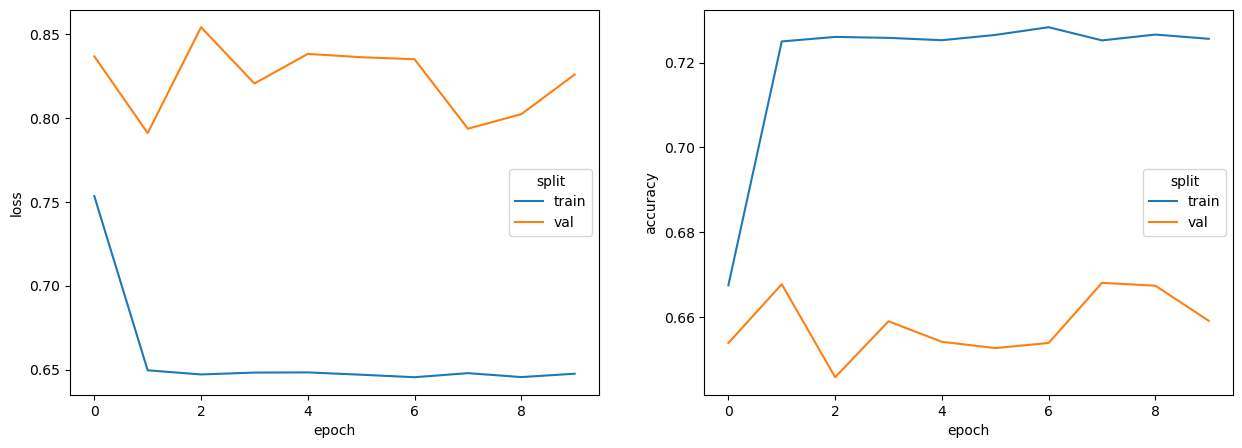

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [12]:
label_mapper = LabelMapper({
    0:0, # 0 is the label for benign (BY)
    1:0, 
    2:0,
    3:1, # 1 is the label for atypical (AT)
    4:1,
    5:2, # 2 is the label for malignant (MT)
    6:2,
})

In [13]:
class RoIDataset(ImageFolder):

    def __getitem__(self, index: int):
        x,y = super().__getitem__(index)
        path = self.imgs[index][0]
        return path, x, y

In [14]:
dataset = RoIDataset(
    root=TEST_DIR,
    target_transform=label_mapper,
    transform=Compose([
        ToTensor(),
    ]),
)

In [15]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)

### Prediciting

In [16]:
def predict(
    model : nn.Module,
    dataloader : DataLoader
) -> tuple[pd.DataFrame, list[str]]:
    
    Y = []
    paths = []
    labels = []
    acc = 0

    model.eval()
    
    with torch.no_grad():
        
        for path,x,y in tqdm(dataloader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)
            y_hat = torch.nn.functional.softmax(y_hat, dim=1)

            acc += torchmetrics.functional.accuracy(y_hat, y, task='multiclass',num_classes=3)

            Y.append(y_hat.cpu())
            paths.extend(path)
            labels.extend(y.cpu().tolist())

    return paths,torch.vstack(Y),labels

In [17]:
paths,y_hat,y = predict(model, loader)

  0%|          | 0/78 [00:00<?, ?it/s]

In [18]:
def get_roi_name(patch_name : str) -> str:
    name, ext = os.path.splitext(patch_name)
    roi_name = '_'.join(name.split('_')[:-1])
    return roi_name + ext

In [19]:
def create_df(paths : list[str],labels : list[int], y_hat : torch.Tensor) -> pd.DataFrame:

    df = pd.DataFrame()
    df["patch_name"] = [os.path.basename(path) for path in paths]
    df["label"] = labels

    df["roi"] = df["patch_name"].apply(get_roi_name)

    df["benign"] = y_hat[:,0].tolist()
    df["atypical"] = y_hat[:,1].tolist()
    df["malignant"] = y_hat[:,2].tolist()

    df['predicted_label'] = torch.argmax(y_hat, dim=1).tolist()

    return df

In [20]:
df = create_df(paths,y, y_hat)

In [21]:
df.head()

,patch_name,label,roi,benign,atypical,malignant,predicted_label
0,BRACS_1286_N_40_0.png,0,BRACS_1286_N_40.png,0.425440,0.516415,0.058145,1
1,BRACS_1286_N_40_1.png,0,BRACS_1286_N_40.png,0.553681,0.414991,0.031328,0
2,BRACS_1286_N_40_10.png,0,BRACS_1286_N_40.png,0.177662,0.463381,0.358957,1
3,BRACS_1286_N_40_11.png,0,BRACS_1286_N_40.png,0.392950,0.573292,0.033758,1
4,BRACS_1286_N_40_12.png,0,BRACS_1286_N_40.png,0.280540,0.518152,0.201308,1


### Predictions analysis (patches persepective)

In [22]:
def make_metric(metric,**kwargs): 

    def _metric(y, y_hat):
        kwargs["y_true"] = y
        kwargs["y_pred"] = y_hat
        return metric(**kwargs)
    
    return _metric

In [23]:
metrics= {
    "accuracy" : accuracy_score,
    "precision_macro" : make_metric(precision_score, average="macro"),
    "precision_micro" : make_metric(precision_score, average="micro"),
    "recall_macro" : make_metric(recall_score, average="macro"),
    "recall_micro" : make_metric(recall_score, average="micro"),
    "f1_macro" : make_metric(f1_score, average="macro"),
    "f1_micro" : make_metric(f1_score, average="micro")
}

In [24]:
def compute_metrics(
    metrics : dict, 
    y : np.ndarray, 
    y_hat : np.ndarray
) -> pd.Series:

    results = {}

    for name, metric in metrics.items():
        results[name] = metric(y, y_hat)

    return pd.Series(results)

In [25]:
compute_metrics(metrics, df["label"], df["predicted_label"])

accuracy           0.631029
precision_macro    0.562636
precision_micro    0.631029
recall_macro       0.559696
recall_micro       0.631029
f1_macro           0.557077
f1_micro           0.631029
dtype: float64

<Axes: >

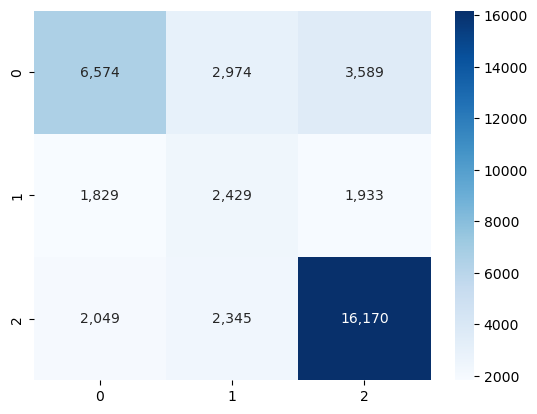

In [26]:
cm = confusion_matrix(df["label"], df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, softvoting)

In [27]:
soft_df = df[["label","roi","benign","atypical","malignant"]] \
    .groupby(by=["label","roi"]) \
    .mean() \
    .reset_index()

In [28]:
soft_df.head()

,label,roi,benign,atypical,malignant
0,0,BRACS_1228_UDH_2.png,0.245737,0.694592,0.059670
1,0,BRACS_1284_UDH_4.png,0.384170,0.236662,0.379168
2,0,BRACS_1286_N_40.png,0.357316,0.449582,0.193102
3,0,BRACS_1286_PB_21.png,0.372454,0.399678,0.227868
4,0,BRACS_1286_PB_5.png,0.326853,0.417944,0.255203


In [29]:
soft_df["predicted_label"] = np.argmax(soft_df[['benign','atypical','malignant']].values, axis=1)

In [30]:
soft_df.head()

,label,roi,benign,atypical,malignant,predicted_label
0,0,BRACS_1228_UDH_2.png,0.245737,0.694592,0.059670,1
1,0,BRACS_1284_UDH_4.png,0.384170,0.236662,0.379168,0
2,0,BRACS_1286_N_40.png,0.357316,0.449582,0.193102,1
3,0,BRACS_1286_PB_21.png,0.372454,0.399678,0.227868,1
4,0,BRACS_1286_PB_5.png,0.326853,0.417944,0.255203,1


In [31]:
compute_metrics(metrics, soft_df["label"], soft_df["predicted_label"])

accuracy           0.624561
precision_macro    0.649870
precision_micro    0.624561
recall_macro       0.640147
recall_micro       0.624561
f1_macro           0.616680
f1_micro           0.624561
dtype: float64

<Axes: >

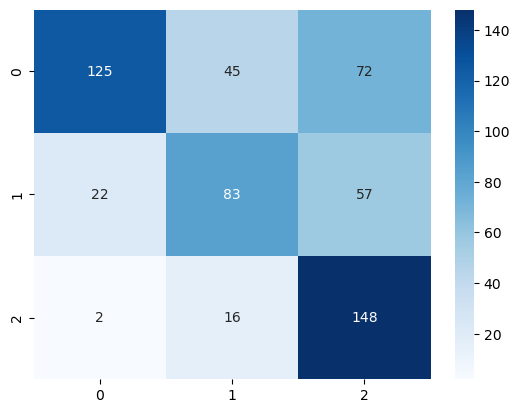

In [32]:
cm = confusion_matrix(soft_df["label"], soft_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')

### Predictions analysis (Roi persepective, hardvoting)

In [33]:
def count(x:np.ndarray) -> float:
    values, counts = np.unique(x, return_counts=True)
    return values[counts.argmax()]


In [34]:
hard_df = df[["label","roi","predicted_label"]] \
    .groupby(by=["label","roi"]) \
    .agg(count) \
    .reset_index()

In [35]:
hard_df.head()

,label,roi,predicted_label
0,0,BRACS_1228_UDH_2.png,1
1,0,BRACS_1284_UDH_4.png,0
2,0,BRACS_1286_N_40.png,1
3,0,BRACS_1286_PB_21.png,1
4,0,BRACS_1286_PB_5.png,1


In [36]:
compute_metrics(metrics, hard_df["label"], hard_df["predicted_label"])

accuracy           0.619298
precision_macro    0.630737
precision_micro    0.619298
recall_macro       0.631501
recall_micro       0.619298
f1_macro           0.611036
f1_micro           0.619298
dtype: float64

<Axes: >

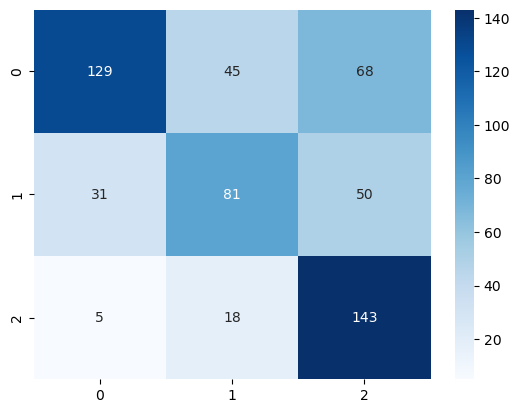

In [37]:
cm = confusion_matrix(hard_df["label"], hard_df["predicted_label"])
sns.heatmap(data=cm,annot=True,fmt=',d',cmap='Blues')